In [1]:
import cv2
import os
import numpy as np

# Define the paths to the input and output folders
input_folder = "/home/shivanshsinghSUREintern2024/iit_bhu/images"
output_folder = "/home/shivanshsinghSUREintern2024/iit_bhu/output_images"

# Create the output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Function to convert an image to grayscale
def to_grayscale(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(frame_gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(frame_gray)

# Function to apply Gaussian blur for noise reduction
def apply_gaussian_blur(frame_gray, kernel_size=5):
    return cv2.GaussianBlur(frame_gray, (kernel_size, kernel_size), 0)

# Function to apply Canny edge detection
def apply_canny_edge_detection(frame_gray, low_threshold=50, high_threshold=150):
    return cv2.Canny(frame_gray, low_threshold, high_threshold)

# Function to normalize the image
def normalize_image(frame_gray):
    return cv2.normalize(frame_gray, None, 0, 255, cv2.NORM_MINMAX)

# Function to apply high-pass filter

# Function to apply auto contrast stretching and subtract mean intensity
def auto_contrast_stretch_and_subtract_mean(frame):
    min_val = np.min(frame)
    max_val = np.max(frame)
    if max_val - min_val == 0:
        normalized_frame = np.zeros_like(frame, dtype=np.uint8)
    else:
        normalized_frame = (frame - min_val) / (max_val - min_val) * 255
        normalized_frame = normalized_frame.astype(np.uint8)
    mean_intensity = np.mean(normalized_frame)
    frame_subtracted = normalized_frame - mean_intensity
    frame_subtracted_normalized = cv2.normalize(frame_subtracted, None, 0, 255, cv2.NORM_MINMAX)
    return frame_subtracted_normalized

# Process each frame in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        input_image_path = os.path.join(input_folder, filename)
        frame = cv2.imread(input_image_path)

        if frame is None:
            print(f"Error loading frame {filename}.")
            continue

        # Preprocess the frame
        frame_gray = to_grayscale(frame)
        frame_clahe = apply_clahe(frame_gray)
        frame_blurred = apply_gaussian_blur(frame_clahe)
        frame_edges = apply_canny_edge_detection(frame_blurred)
        frame_normalized = normalize_image(frame_edges)
        frame_final = auto_contrast_stretch_and_subtract_mean(frame_normalized)

        output_image_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_image_path, frame_final)

        print(f"Processed frame {filename} and saved to {output_image_path}.")

print("All frames processed and saved.")


Processed frame frame_2983.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_2983.jpg.
Processed frame frame_0002.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0002.jpg.
Processed frame frame_3178.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_3178.jpg.
Processed frame frame_1961.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_1961.jpg.
Processed frame frame_3024.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_3024.jpg.
Processed frame frame_2712.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_2712.jpg.
Processed frame frame_2837.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_2837.jpg.
Processed frame frame_2619.jpg and saved to /home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_2619.jpg.
Processed frame frame_1079.jpg and saved to /home/shivanshsinghSUREinter

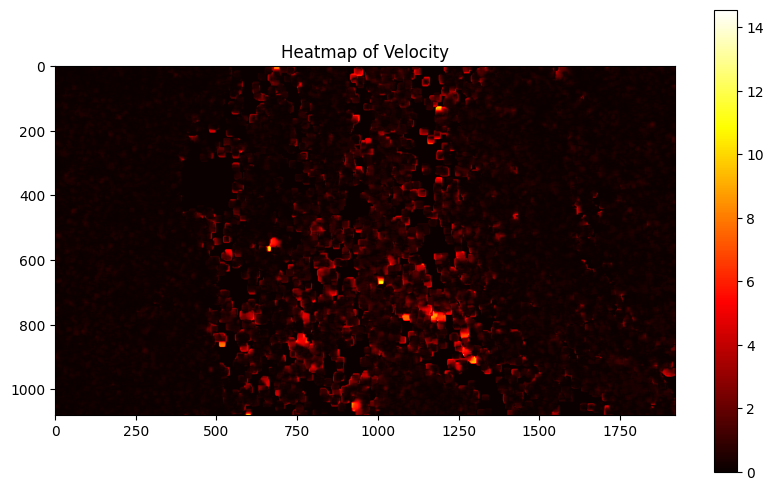

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# File paths for the two frames
frame1_path = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0004.jpg'
frame2_path = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0005.jpg'

# Read the frames from the file paths
frame1 = cv2.imread(frame1_path)
frame2 = cv2.imread(frame2_path)

# Check if frames were read correctly
if frame1 is None or frame2 is None:
    print("Error loading frames.")
    exit()

# Convert frames to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Calculate optical flow using Farneback's method
flow = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, None,
                                    pyr_scale=0.5, levels=3, winsize=15,
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Calculate the magnitude and angle of the flow
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
# Normalize the magnitude for better visualization
normalized_magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
# Create a heatmap using the normalized magnitude
plt.figure(figsize=(10, 6))
plt.title("Heatmap of Velocity")
heatmap = plt.imshow(magnitude, cmap='hot')
plt.colorbar(heatmap)
plt.show()


In [5]:

# -*- coding: utf-8 -*-
"""
Project: Particle Image Velocimetry (PIV) code -> function!
@author: A. F. Forughi (Aug. 2020, Last update: Sept. 2022)
"""

# %% Libraries:
import numpy as np
from tqdm import tqdm # pip install tqdm
from numba import jit # pip install numba
from joblib import Parallel, delayed

# %% Functions:
@jit(nopython=True)
def corr2(c1,c2): # Cross-correlation
    c1-=c1.mean()
    c2-=c2.mean()
    c12=(c1*c1).sum()*(c2*c2).sum()
    if c12>0.0:
        return (c1*c2).sum()/np.sqrt(c12)
    return -1.0

def fixer(vecx,vecy,vec,rij,r_limit,i_fix): # Fixing the irregular vectors (Normalized Median Test and low Correlation coeff.)
    fluc=np.zeros(vec.shape)
    for j in range(1,vec.shape[1]-1):
        for i in range(1,vec.shape[0]-1):
            neigh_x=np.array([])
            neigh_y=np.array([])
            for ii in range(-1,2):
                for jj in range(-1,2):
                    if ii==0 and jj==0: continue
                    neigh_x=np.append(neigh_x,vecx[i+ii,j+jj]) # Neighbourhood components
                    neigh_y=np.append(neigh_y,vecy[i+ii,j+jj])
            res_x=neigh_x-np.median(neigh_x) # Residual
            res_y=neigh_y-np.median(neigh_y)

            res_s_x=np.abs(vecx[i,j]-np.median(neigh_x))/(np.median(np.abs(res_x))+0.1) # Normalized Residual (Epsilon=0.1)
            res_s_y=np.abs(vecy[i,j]-np.median(neigh_y))/(np.median(np.abs(res_y))+0.1)

            fluc[i,j]=np.sqrt(res_s_x*res_s_x+res_s_y*res_s_y) # Normalized Fluctuations

    i_disorder=0
    for ii in range(i_fix): # Correction Cycle for patches of bad data
        i_disorder=0
        vec_diff=0.0
        for j in range(1,vec.shape[1]-1):
            for i in range(1,vec.shape[0]-1):
                if fluc[i,j]>2.0 or (rij[i,j]<r_limit): # Fluctuation threshold = 2.0
                    i_disorder+=1
                    vecx[i,j]=0.25*(vecx[i+1,j]+vecx[i-1,j]+vecx[i,j+1]+vecx[i,j-1]) # Bilinear Fix
                    vecy[i,j]=0.25*(vecy[i+1,j]+vecy[i-1,j]+vecy[i,j+1]+vecy[i,j-1])
                    vec_diff+=(vec[i,j]-np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j]))**2.0
                    vec[i,j]=np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j])

        if i_disorder==0 or vec.mean()==0.0: break # No need for correction
        correction_residual=vec_diff/(i_disorder*np.abs(vec.mean()))
        if correction_residual<1.0e-20: break # Converged!
    if ii==i_fix-1: print("Maximum correction iteration was reached!")
    return vecx,vecy,vec,i_disorder,ii


def subpix(R,axis): # Subpixle resolution (parabolic-Gaussian fit)
    dum=np.floor(np.argmax(R)/R.shape[0])
    R_x=int(dum) #vecy
    R_y=int(np.argmax(R)-dum*R.shape[0])  #vecx
    r=R[R_x,R_y]
    if np.abs(r-1.0)<0.01: return 0.0
    try: # Out of bound at the edges:
        if axis == 'y': #For vecy
            r_e=R[R_x+1,R_y]
            r_w=R[R_x-1,R_y]
        else:          #For Vecx
            r_e=R[R_x,R_y+1]
            r_w=R[R_x,R_y-1]
        if r_e>0.0 and r_w>0.0 and r>0.0: # Gaussian if possible (resolves pick locking)
            r_e=np.log(r_e)
            r_w=np.log(r_w)
            r=np.log(r)
        if (r_e+r_w-2*r)!=0.0:
            if np.abs((r_w-r_e)/(2.0*(r_e+r_w-2*r)))<1.0 and np.abs(r_e+1)>0.01 and np.abs(r_w+1)>0.01:
                return (r_w-r_e)/(2.0*(r_e+r_w-2*r))
        return 0.0
    except:
        return 0.0



#  Search Algorithm:
def piv(img_1,img_2,iw,sw,r_limit,i_fix,l_scale,t_scale,cores):

    # i_fix,l_scale,t_scale

    ia,ja = img_1.shape
    iw=int(2*np.floor((iw+1)/2)-1) # Even->Odd
    sw=int(2*np.floor((sw+1)/2)-1)
    margin=int((sw-iw)/2)
    im=int(2*np.floor((ia-1-iw)/(iw-1))) # Number of I.W.s in x direction
    jm=int(2*np.floor((ja-1-iw)/(iw-1))) # Number of I.W.s in y direction

    vecx=np.zeros((im,jm)) # x-Displacement
    vecy=np.zeros((im,jm)) # y-Displacement
    vec=np.zeros((im,jm)) # Magnitude
    rij=np.zeros((im,jm)) # Correlation coeff.

    def jay_walker(j):
        ivecx=np.zeros(im) # x-Displacement
        ivecy=np.zeros(im) # y-Displacement
        ivec=np.zeros(im)  # Magnitude
        irij=np.zeros(im)  # Correlation coeff.

        j_d=int(j*(iw-1)/2) # Bottom bound
        j_u=j_d+iw          # Top bound
        sw_d=max(0,j_d-margin) # First Row
        sw_d_diff=max(0,j_d-margin)-(j_d-margin)
        sw_u=min(ja-1,j_u+margin) # Last Row

        for i in range(im):
            i_l=int(i*(iw-1)/2) # Left bound
            i_r=i_l+iw          # Right bound
            sw_l=max(0,i_l-margin) # First column
            sw_l_diff=max(0,i_l-margin)-(i_l-margin)
            sw_r=min(ia-1,i_r+margin) # Last column

            R=np.zeros((sw-iw+1,sw-iw+1))-1 # Correlation Matrix
            c1=np.array(img_1[i_l:i_l+iw,j_d:j_d+iw]) # IW from 1st image
            for jj in range(sw_d,sw_u+1-iw):
                for ii in range(sw_l,sw_r+1-iw):
                    c2=np.array(img_2[ii:ii+iw,jj:jj+iw]) # IW from 2nd image
                    R[ii-sw_l,jj-sw_d]=corr2(c1,c2)
            irij[i]=R.max()
            if irij[i]>=r_limit:
                dum=np.floor(np.argmax(R)/R.shape[0])
                ivecy[i]=dum-(margin-sw_l_diff)+subpix(R,'y')
                ivecx[i]=np.argmax(R)-dum*R.shape[0]-(margin-sw_d_diff)+subpix(R,'x')
                ivec[i]=np.sqrt(ivecx[i]*ivecx[i]+ivecy[i]*ivecy[i])
            else:
                ivecx[i]=0.0;ivecy[i]=0.0;ivec[i]=0.0
        return j,ivec, ivecx, ivecy, irij


    reconst = Parallel(n_jobs=cores)(delayed(jay_walker)(j) for j in tqdm(range(jm)))
    for reoncs_row in reconst:
        vec[:,reoncs_row[0]], vecx[:,reoncs_row[0]], vecy[:,reoncs_row[0]], rij[:,reoncs_row[0]] = reoncs_row[1],reoncs_row[2],reoncs_row[3],reoncs_row[4]


    # %% Corrections:
    vecx,vecy,vec,i_disorder,i_cor_done=fixer(vecx,vecy,vec,rij,r_limit,i_fix)

    # %% Applying the scales:
    X, Y = np.meshgrid(np.arange(0.5*iw, 0.5*iw*(jm+1), 0.5*iw),
                       np.arange(0.5*iw, 0.5*iw*(im+1), 0.5*iw))
    X*=l_scale
    Y*=l_scale

    vecx*=(l_scale/t_scale);vecy*=(l_scale/t_scale);vec*=(l_scale/t_scale);

    return X, Y, vecx, vecy, vec, rij


  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 74/74 [00:00<00:00, 165.20it/s]


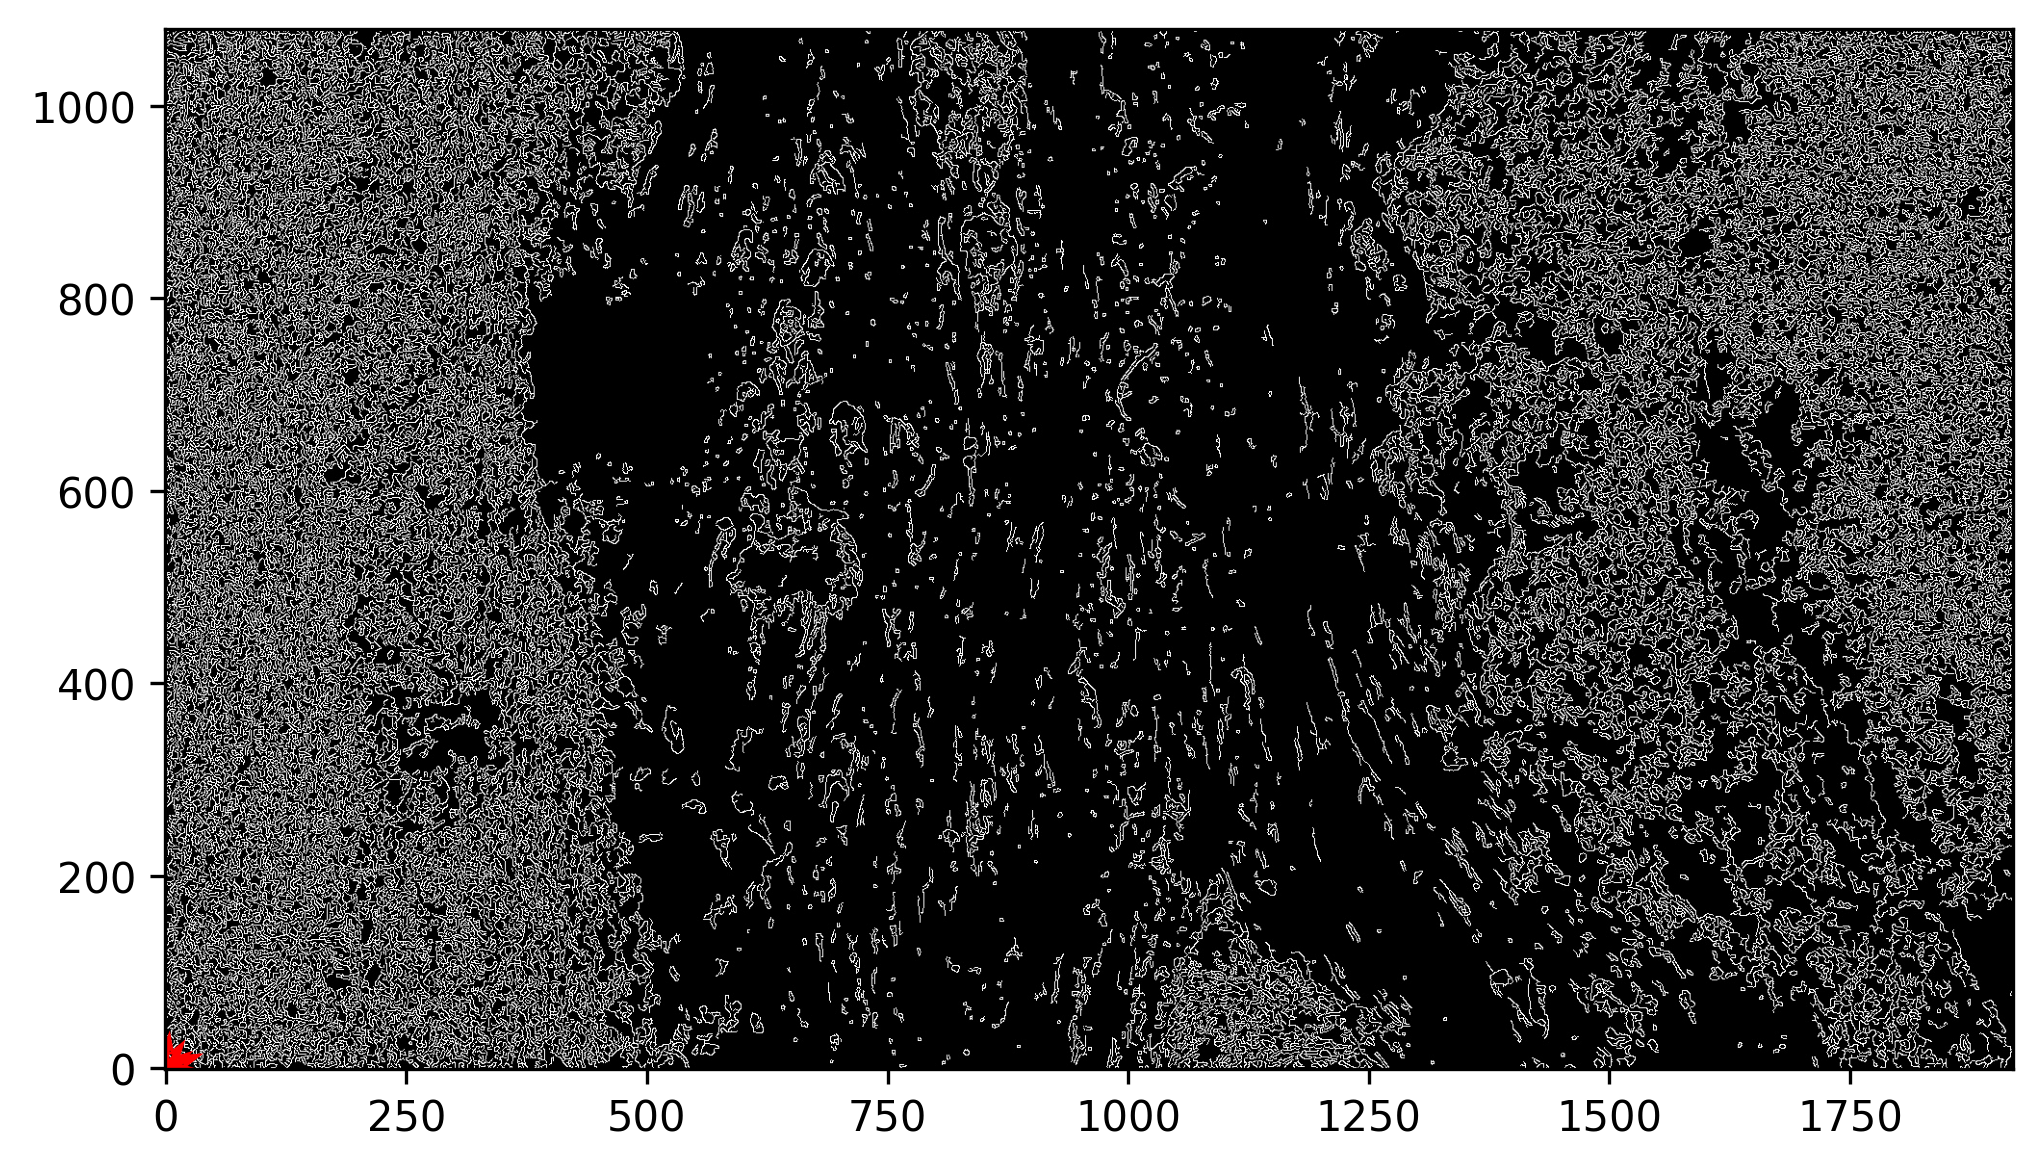

rij min: -1.0
rij max: 1.0000001192092896


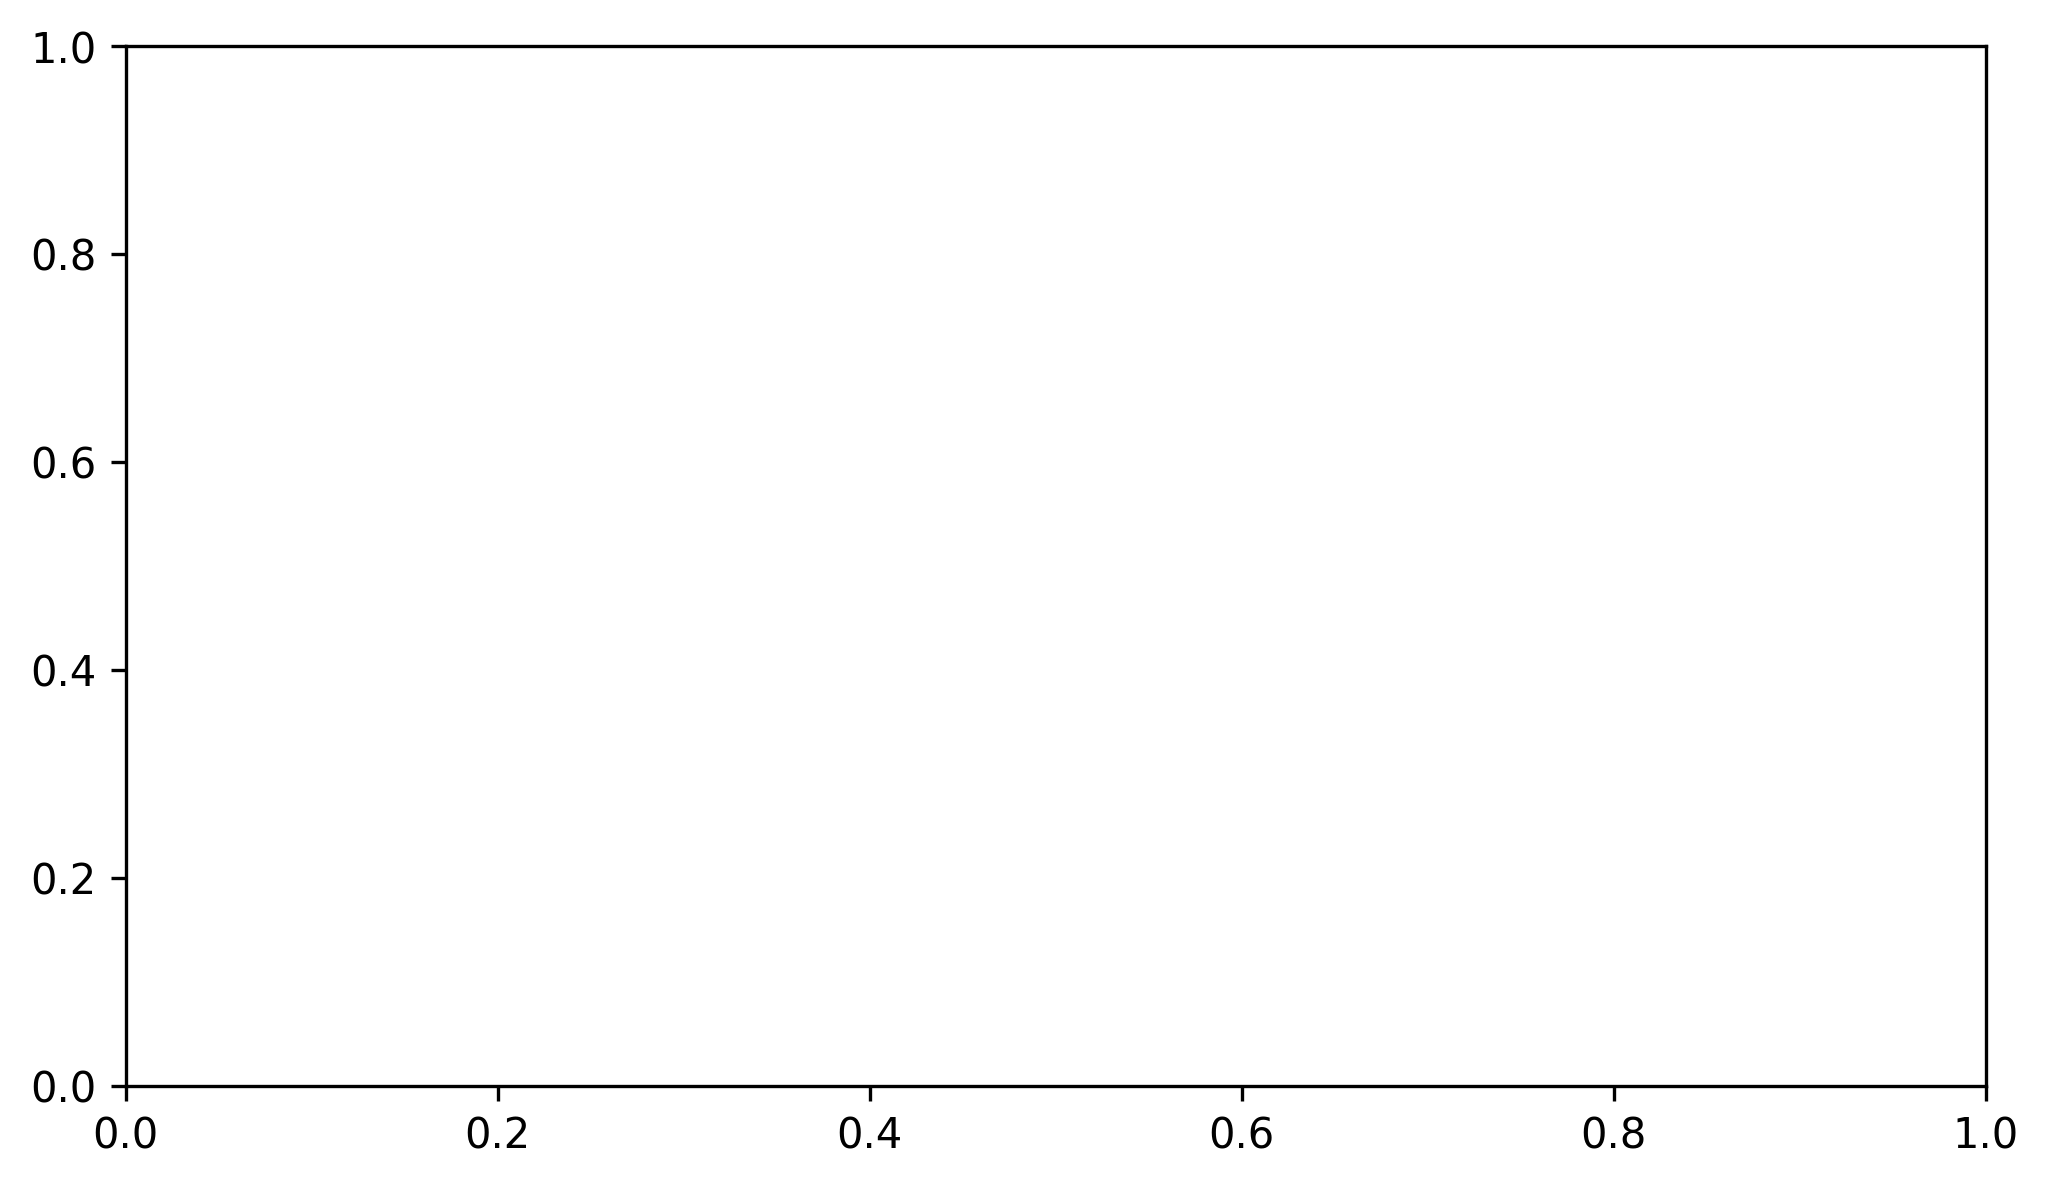

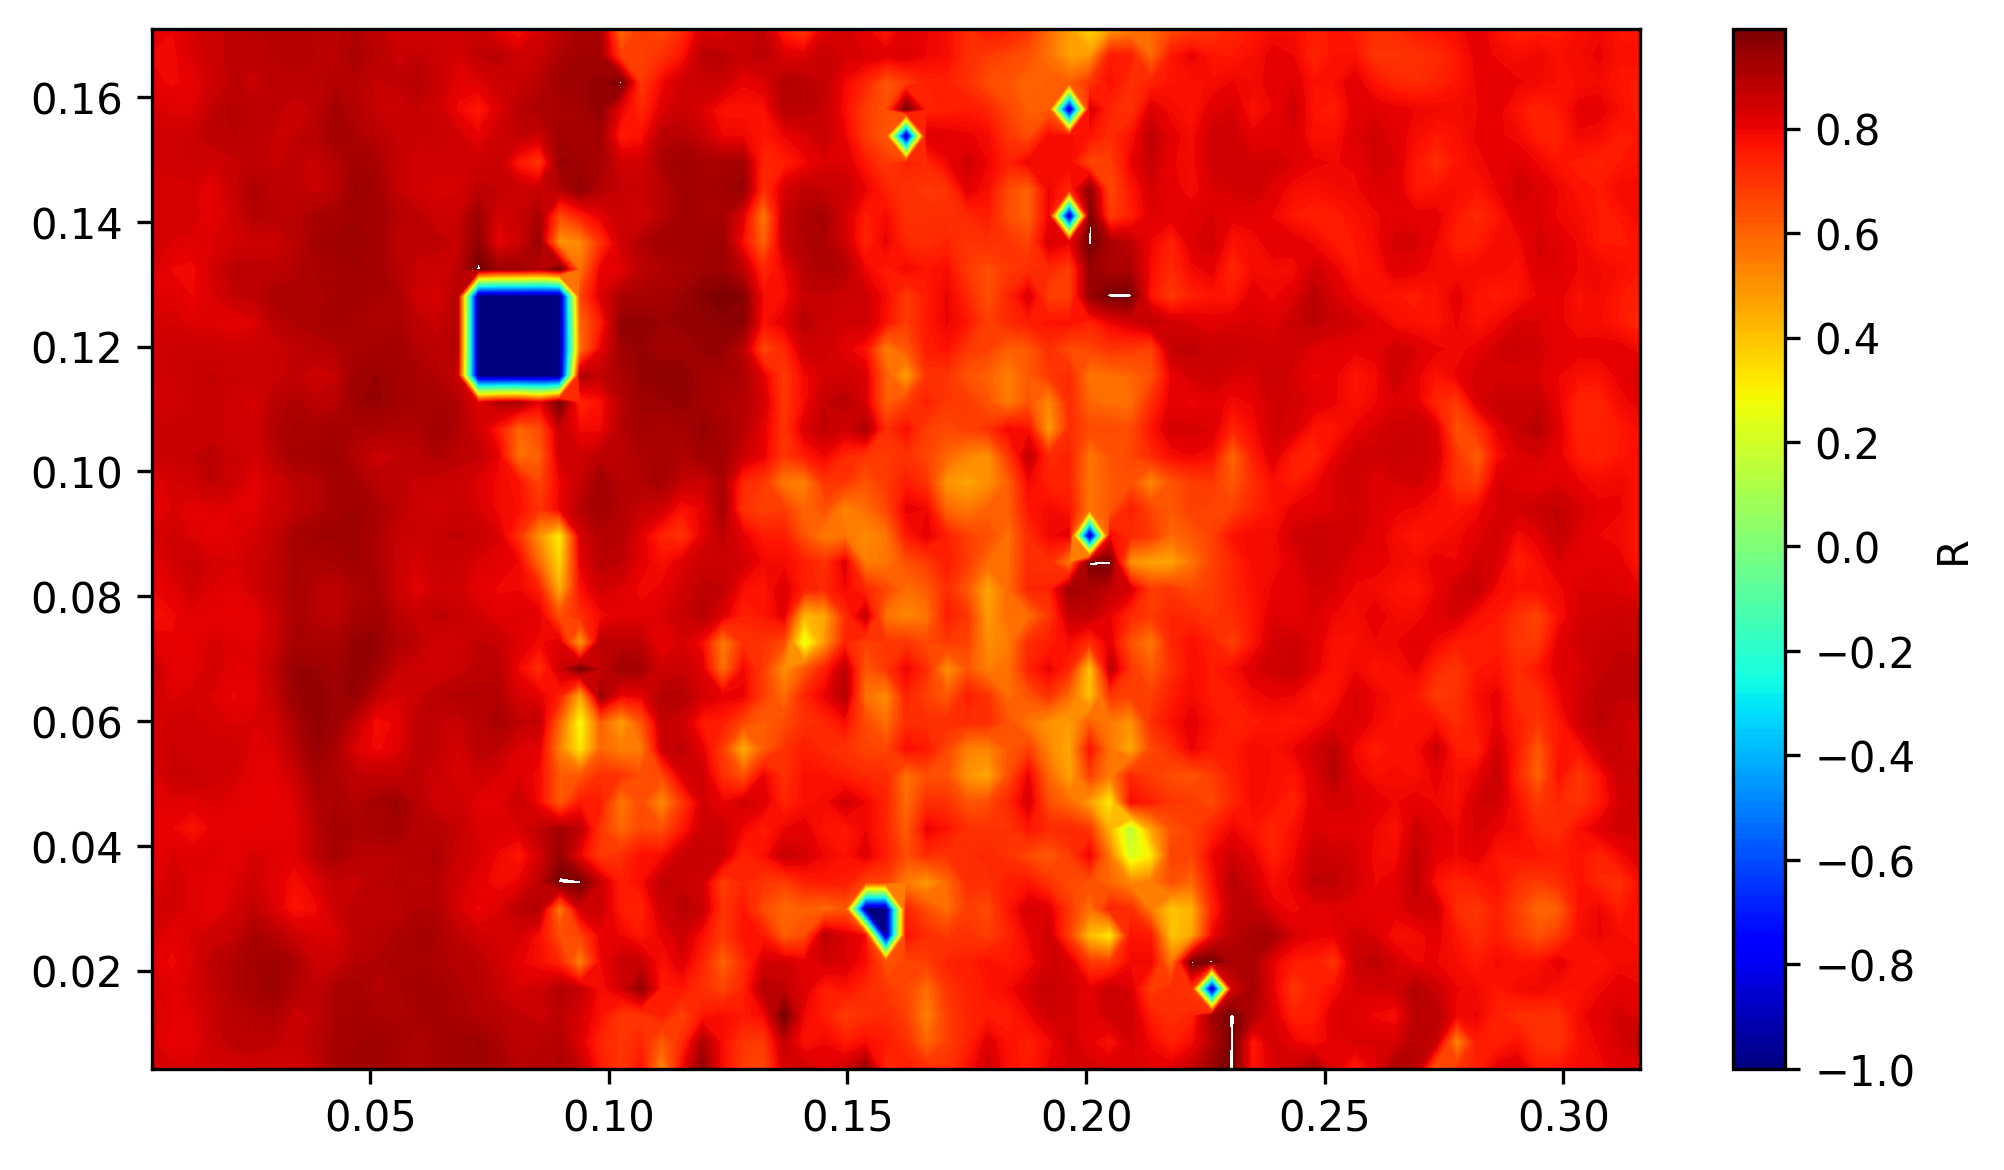

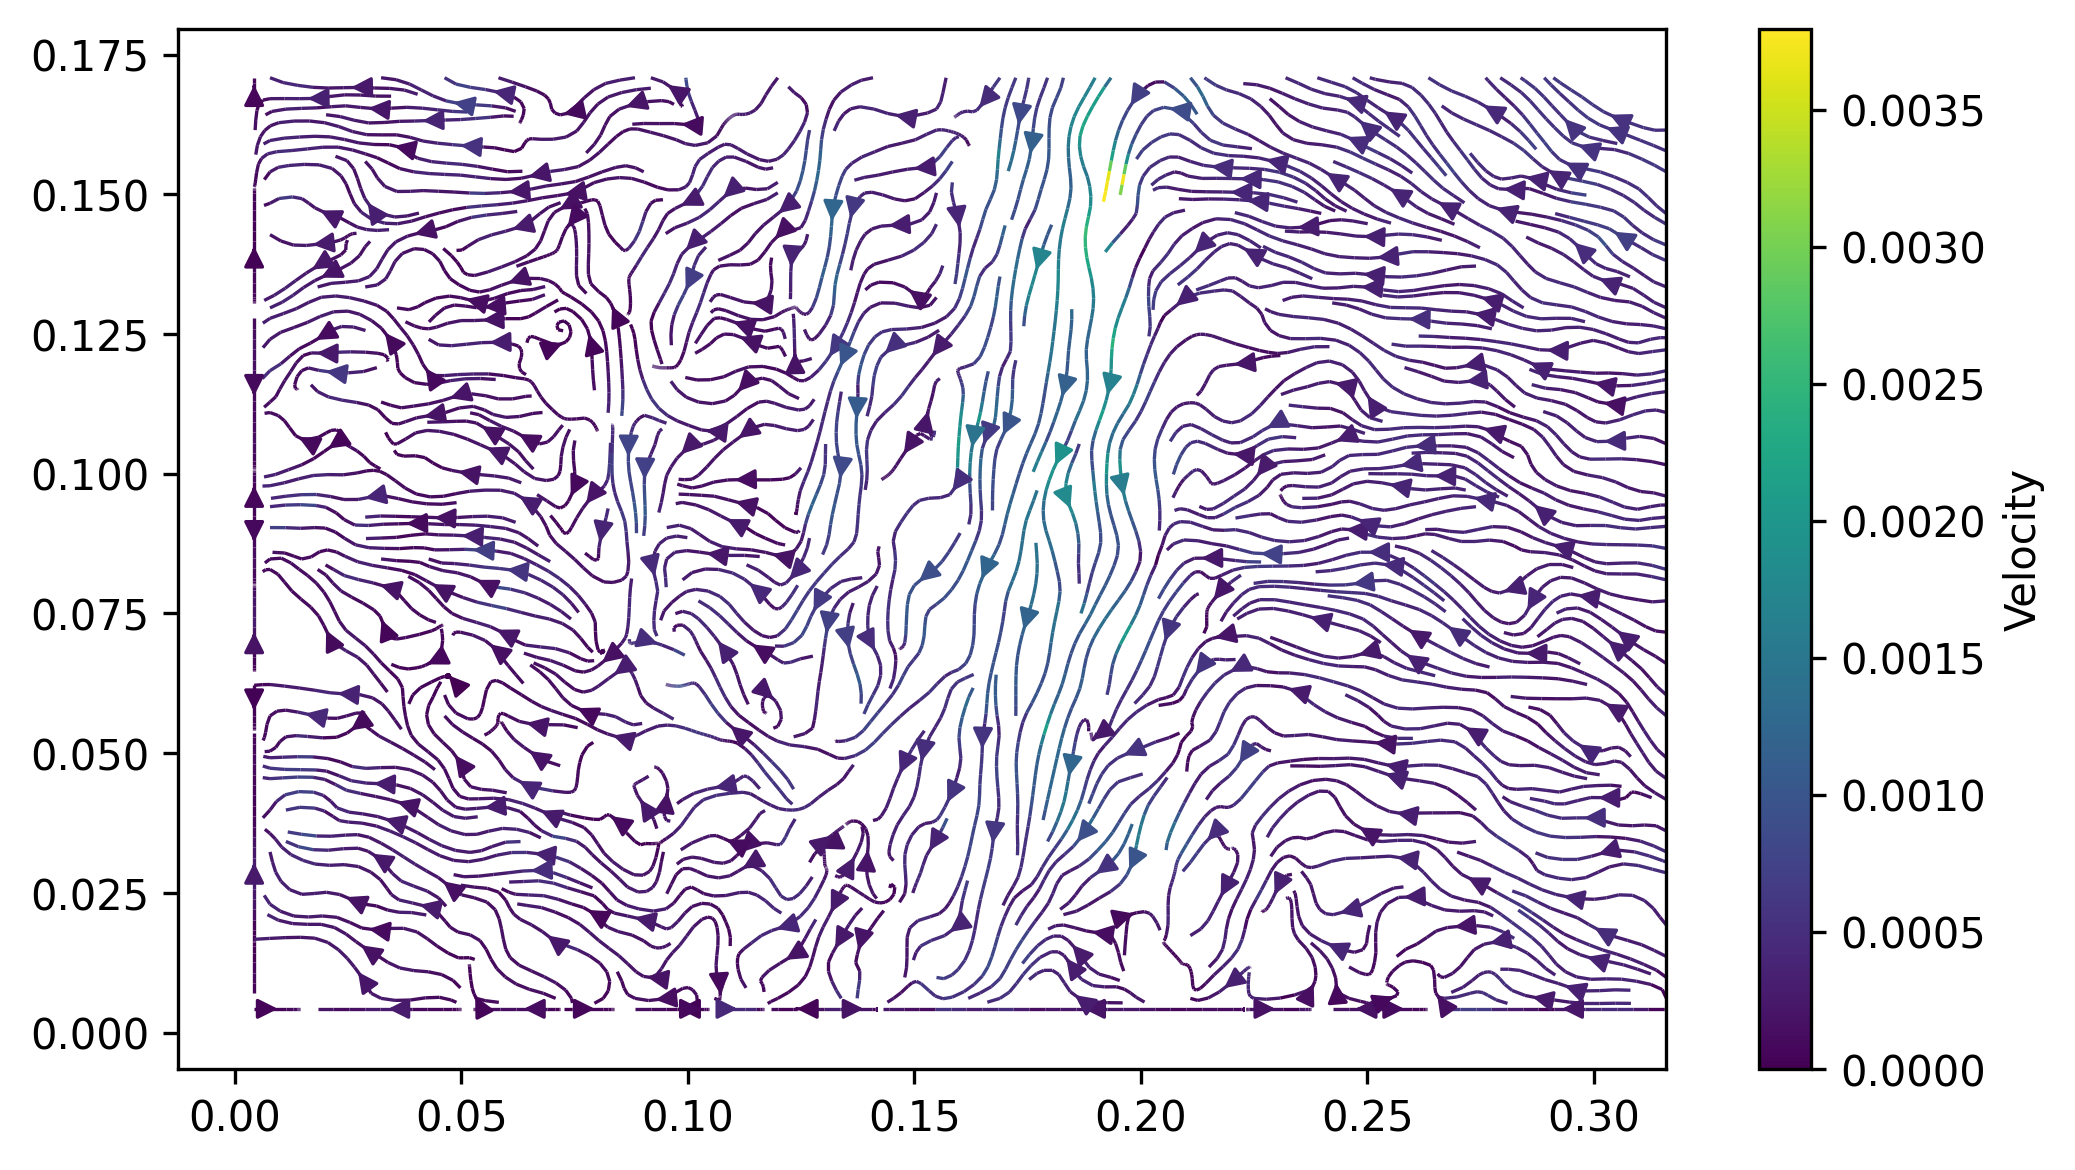

In [6]:
# -*- coding: utf-8 -*-
"""
Project: Particle Image Velocimetry (PIV) code!
         Sample code to call the function!
@author: A. F. Forughi (Aug. 2020, Last update: Jun. 2021)
"""

# %% Libraries:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# from piv_lib import piv # Importing the PIV function from piv_lib.py


# %% Loading the images:
img_1 = (np.flip(cv2.imread('/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0000.jpg', 0),0)).astype('float32') # Read Grayscale
img_2 = (np.flip(cv2.imread('/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0001.jpg', 0),0)).astype('float32')


# %% Setting the PIV parameters:
iw=51 # Interrodation Windows Sizes (pixel)
sw=81 # Search Windows Sizes (sw > iw) (pixel)

r_limit=0.5   # minimum acceptable correlation coefficient. If you're not sure start with 0.6

i_fix=500     # Number of maximum correction cycles ; 0 means no correction

l_scale=0.0001675   # spatial scale [m/pixel] ; 1 means no size scaling
t_scale=0.033333333  # time step = 1/frame_rate [s/frame] ; 1 means no time scaling

cores=-1 # Number of parallel processes: 1 = no parallel processing ; 2 and above = number of parallel processes ; -1 = maximum

# %% Runing PIV function:
""" *** Here are the function's arguments and returned values ***

Arguments:
    first image as a Numpy matrix (img_1)
    second image as a Numpy matrix (img_2)
    size of the introgation window (IW)
    Size of the search window (SW)
    Minimum acceptable correlation coefficient (r_limit)
    Number of maximum correction cycles (i_fix)
    Spatial scale [m/pixel]
    Time step = 1/frame_rate [s/frame]
    cores = Number of parallel processes

Returned values:
    X Position of the vectors (X)
    Y Position of the vectors (Y)
    X-velocity components (vecx)
    Y-velocity components (vecy)
    Velocity vector size (vec)
    Correlation coefficient of each intoregation window (rij)
"""

X, Y, vecx, vecy, vec, rij = piv(img_1,img_2,iw,sw,r_limit,i_fix,l_scale,t_scale,cores)


# %% Exporting Data in as a Numpy file:
np.savez('results.npz', X=X, Y=Y, vecx=vecx, vecy=vecy, vec=vec, rij=rij)

res=np.load('results.npz'); X=res['X']; Y=res['Y']; vecx=res['vecx']; vecy=res['vecy']; vec=res['vec']; rij=res['rij']; # Load saved data


# %% Generating graphs:

ia,ja = img_1.shape
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.imshow(img_1, cmap='gray', vmin=0, vmax=255,origin='lower')     # Comment to not superimpose on image
q = ax.quiver(X, Y, vecx, vecy,units='width',color="red")
plt.show()

# Printing the minimum and maximum values of rij
print("rij min:", rij.min())
print("rij max:", rij.max())

# Adjust the step size in np.arange to generate more levels within the range of rij
step_size = 0.01  # You can try adjusting this value if necessary

# Adjust the function call with updated levels
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
levels = np.arange(rij.min(), 0.3, step_size)

# Check the length of the levels array
if len(levels) < 2:
    print("Warning: Adjusting step size to increase number of levels")
    step_size = 0.001
    levels = np.arange(rij.min(), min(rij.max() + 0.1, 1.0), step_size)
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.contourf(X[0],np.transpose(Y)[0],rij,cmap='jet',levels=np.arange(rij.min(),min(rij.max()+0.1,1.0),0.01))
plt.colorbar(label='R')
plt.show()

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.streamplot(X, Y, vecx, vecy,density=3,linewidth=0.8,color=vec)
plt.colorbar(label='Velocity')
plt.show()

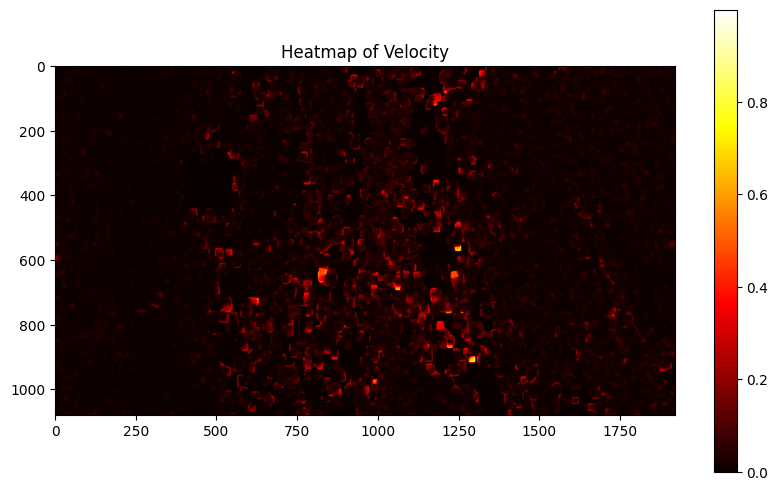

In [7]:
# File paths for the two frames
frame1_path = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0000.jpg'
frame2_path = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0001.jpg'

# Read the frames from the file paths
frame1 = cv2.imread(frame1_path)
frame2 = cv2.imread(frame2_path)

# Check if frames were read correctly
if frame1 is None or frame2 is None:
    print("Error loading frames.")
    exit()

# Convert frames to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Calculate optical flow using Farneback's method
flow = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, None,
                                    pyr_scale=0.5, levels=3, winsize=15,
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Calculate the magnitude and angle of the flow
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Normalize the magnitude values to range from 0 to 1
normalized_magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

# Create a heatmap using the normalized magnitude of the flow
plt.figure(figsize=(10, 6))
plt.title("Heatmap of Velocity")
heatmap = plt.imshow(normalized_magnitude, cmap='hot')
plt.colorbar(heatmap)
plt.show()


In [8]:
import numpy as np

# Load the NPZ file
data = np.load('results.npz')

# Access individual arrays from the loaded data
X = data['X']
Y = data['Y']
vecx = data['vecx']
vecy = data['vecy']
vec = data['vec']
rij = data['rij']

# Print vecx
print("vecx:")
print(vecx[0])


vecx:
[[ 0.00000000e+00  3.92523137e-05  1.30571867e-04 ... -4.93133960e-04
  -2.78134985e-04 -2.38135168e-06]
 [ 0.00000000e+00 -3.40188947e-04 -1.35538293e-04 ... -4.13628764e-04
  -3.31434094e-04 -9.54229278e-06]
 [ 0.00000000e+00 -4.19290647e-04 -3.83339168e-04 ... -3.04835594e-04
  -3.21656013e-04 -2.99953746e-04]
 ...
 [ 0.00000000e+00 -1.66264047e-04 -3.40144190e-04 ... -4.33869566e-04
  -5.67524923e-04 -4.92168909e-04]
 [ 0.00000000e+00 -1.49176296e-04 -3.25494406e-04 ... -3.39670578e-04
  -5.44462875e-04 -5.99597837e-04]
 [ 0.00000000e+00 -2.32160936e-04 -4.78887518e-04 ... -6.62600983e-04
  -6.09654005e-04 -6.29528814e-04]]


In [14]:
import numpy as np

# Load data
res = np.load('results.npz')
X = res['X']
Y = res['Y']
vecx = res['vecx']
vecy = res['vecy']
vec = res['vec']
rij = res['rij']

# Assuming you have frames indexed as 0, 1, 2, ..., N-1
num_frames = X.shape[1]
print(X.shape)

# Frame rate
fps = 30

# Time step between consecutive frames
time_step = 1 / fps

# Iterate through pairs of frames
for frame_idx in range(num_frames - 1):
    # Velocity components for the current pair of frames
    vx = vecx[:, frame_idx] / time_step
    vy = vecy[:, frame_idx] / time_step
    
    # Magnitude of velocity
    v = np.sqrt(vx**2 + vy**2)
    
    print(f"Frame {frame_idx} to Frame {frame_idx + 1}: Average Velocity = {np.mean(v):.2f} m/s")


(40, 74)
Frame 0 to Frame 1: Average Velocity = 0.00 m/s
Frame 1 to Frame 2: Average Velocity = 0.01 m/s
Frame 2 to Frame 3: Average Velocity = 0.01 m/s
Frame 3 to Frame 4: Average Velocity = 0.01 m/s
Frame 4 to Frame 5: Average Velocity = 0.01 m/s
Frame 5 to Frame 6: Average Velocity = 0.01 m/s
Frame 6 to Frame 7: Average Velocity = 0.01 m/s
Frame 7 to Frame 8: Average Velocity = 0.00 m/s
Frame 8 to Frame 9: Average Velocity = 0.01 m/s
Frame 9 to Frame 10: Average Velocity = 0.01 m/s
Frame 10 to Frame 11: Average Velocity = 0.01 m/s
Frame 11 to Frame 12: Average Velocity = 0.01 m/s
Frame 12 to Frame 13: Average Velocity = 0.01 m/s
Frame 13 to Frame 14: Average Velocity = 0.01 m/s
Frame 14 to Frame 15: Average Velocity = 0.01 m/s
Frame 15 to Frame 16: Average Velocity = 0.01 m/s
Frame 16 to Frame 17: Average Velocity = 0.01 m/s
Frame 17 to Frame 18: Average Velocity = 0.00 m/s
Frame 18 to Frame 19: Average Velocity = 0.00 m/s
Frame 19 to Frame 20: Average Velocity = 0.01 m/s
Frame 20 t

In [1]:
# %% Libraries:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm 
from numba import jit 
from joblib import Parallel, delayed

# %% Functions:
@jit(nopython=True)
def corr2(c1,c2): # Cross-correlation
    c1-=c1.mean()
    c2-=c2.mean()
    c12=(c1*c1).sum()*(c2*c2).sum()
    if c12>0.0:
        return (c1*c2).sum()/np.sqrt(c12)
    return -1.0

def fixer(vecx,vecy,vec,rij,r_limit,i_fix): # Fixing the irregular vectors (Normalized Median Test and low Correlation coeff.)
    fluc=np.zeros(vec.shape)
    for j in range(1,vec.shape[1]-1):
        for i in range(1,vec.shape[0]-1):
            neigh_x=np.array([])
            neigh_y=np.array([])
            for ii in range(-1,2):
                for jj in range(-1,2):
                    if ii==0 and jj==0: continue
                    neigh_x=np.append(neigh_x,vecx[i+ii,j+jj]) # Neighbourhood components
                    neigh_y=np.append(neigh_y,vecy[i+ii,j+jj])
            res_x=neigh_x-np.median(neigh_x) # Residual
            res_y=neigh_y-np.median(neigh_y)
            
            res_s_x=np.abs(vecx[i,j]-np.median(neigh_x))/(np.median(np.abs(res_x))+0.1) # Normalized Residual (Epsilon=0.1)
            res_s_y=np.abs(vecy[i,j]-np.median(neigh_y))/(np.median(np.abs(res_y))+0.1)
            
            fluc[i,j]=np.sqrt(res_s_x*res_s_x+res_s_y*res_s_y) # Normalized Fluctuations
    # plt.contourf(fluc,levels=np.arange(2,200,0.1))#,vmin=0.0,vmax=2 # To see the outliers
    # plt.colorbar(label='Normalized Fluctuation')
    
    i_disorder=0
    for ii in range(i_fix): # Correction Cycle for patches of bad data
        i_disorder=0
        vec_diff=0.0
        for j in range(1,vec.shape[1]-1):
            for i in range(1,vec.shape[0]-1):
                if fluc[i,j]>2.0 or (rij[i,j]<r_limit): # Fluctuation threshold = 2.0
                    i_disorder+=1
                    vecx[i,j]=0.25*(vecx[i+1,j]+vecx[i-1,j]+vecx[i,j+1]+vecx[i,j-1]) # Bilinear Fix
                    vecy[i,j]=0.25*(vecy[i+1,j]+vecy[i-1,j]+vecy[i,j+1]+vecy[i,j-1])
                    vec_diff+=(vec[i,j]-np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j]))**2.0
                    vec[i,j]=np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j])
                    
        if i_disorder==0 or vec.mean()==0.0: break # No need for correction
        correction_residual=vec_diff/(i_disorder*np.abs(vec.mean()))
        if correction_residual<1.0e-20: break # Converged!
    if ii==i_fix-1: print("Maximum correction iteration was reached!")
    return vecx,vecy,vec,i_disorder,ii


def subpix(R,axis): # Subpixle resolution (parabolic-Gaussian fit)
    dum=np.floor(np.argmax(R)/R.shape[0])    
    R_x=int(dum) #vecy
    R_y=int(np.argmax(R)-dum*R.shape[0])  #vecx
    r=R[R_x,R_y]
    if np.abs(r-1.0)<0.01: return 0.0
    try: # Out of bound at the edges:
        if axis == 'y': #For vecy
            r_e=R[R_x+1,R_y]
            r_w=R[R_x-1,R_y]
        else:          #For Vecx
            r_e=R[R_x,R_y+1]
            r_w=R[R_x,R_y-1]
        if r_e>0.0 and r_w>0.0 and r>0.0: # Gaussian if possible (resolves pick locking)
            r_e=np.log(r_e)
            r_w=np.log(r_w)
            r=np.log(r)
        if (r_e+r_w-2*r)!=0.0:
            if np.abs((r_w-r_e)/(2.0*(r_e+r_w-2*r)))<1.0 and np.abs(r_e+1)>0.01 and np.abs(r_w+1)>0.01:
                return (r_w-r_e)/(2.0*(r_e+r_w-2*r))
        return 0.0
    except:
        return 0.0

# %% loading images and setting the parameters:

img_1 = (np.flip(cv2.imread('/home/shivanshsinghSUREintern2024/iit_bhu/images1/frame_0000.jpg', 0),0)).astype('float32') # Read Grayscale
img_2 = (np.flip(cv2.imread('/home/shivanshsinghSUREintern2024/iit_bhu/images1/frame_0001.jpg', 0),0)).astype('float32')

i_fix=500     # Number of maximum correction cycles
r_limit=0.5   # minimum acceptable correlation coefficient
l_scale=1.0   # spatial scale [m/pixel]
t_scale=1.0   # time step = 1/frame_rate [s/frame]

iw=51 # Interrodation Windows Sizes (pixel)
sw=81 # Search Windows Sizes (sw > iw) (pixel)

cores=-1 # Number of parallel jobs: 1 = no parallel processing ; 2 and above = number of parallel processes ; -1 = maximum

# %% Search Algorithm:
ia,ja = img_1.shape
iw=int(2*np.floor((iw+1)/2)-1) # Even->Odd
sw=int(2*np.floor((sw+1)/2)-1)
margin=int((sw-iw)/2)
im=int(2*np.floor((ia-1-iw)/(iw-1))) # Number of I.W.s in x direction
jm=int(2*np.floor((ja-1-iw)/(iw-1))) # Number of I.W.s in y direction

vecx=np.zeros((im,jm)) # x-Displacement
vecy=np.zeros((im,jm)) # y-Displacement
vec=np.zeros((im,jm)) # Magnitude
rij=np.zeros((im,jm)) # Correlation coeff.

def jay_walker(j):
    ivecx=np.zeros(im) # x-Displacement
    ivecy=np.zeros(im) # y-Displacement
    ivec=np.zeros(im)  # Magnitude
    irij=np.zeros(im)  # Correlation coeff.
    
    j_d=int(j*(iw-1)/2) # Bottom bound
    j_u=j_d+iw          # Top bound
    sw_d=max(0,j_d-margin) # First Row
    sw_d_diff=max(0,j_d-margin)-(j_d-margin)
    sw_u=min(ja-1,j_u+margin) # Last Row
    
    for i in range(im):
        i_l=int(i*(iw-1)/2) # Left bound
        i_r=i_l+iw          # Right bound
        sw_l=max(0,i_l-margin) # First column
        sw_l_diff=max(0,i_l-margin)-(i_l-margin)
        sw_r=min(ia-1,i_r+margin) # Last column
        
        R=np.zeros((sw-iw+1,sw-iw+1))-1 # Correlation Matrix
        c1=np.array(img_1[i_l:i_l+iw,j_d:j_d+iw]) # IW from 1st image
        for jj in range(sw_d,sw_u+1-iw):
            for ii in range(sw_l,sw_r+1-iw):
                c2=np.array(img_2[ii:ii+iw,jj:jj+iw]) # IW from 2nd image
                R[ii-sw_l,jj-sw_d]=corr2(c1,c2)
        irij[i]=R.max()
        if irij[i]>=r_limit:
            dum=np.floor(np.argmax(R)/R.shape[0])
            ivecy[i]=dum-(margin-sw_l_diff)+subpix(R,'y')
            ivecx[i]=np.argmax(R)-dum*R.shape[0]-(margin-sw_d_diff)+subpix(R,'x')
            ivec[i]=np.sqrt(ivecx[i]*ivecx[i]+ivecy[i]*ivecy[i])
        else:
            ivecx[i]=0.0;ivecy[i]=0.0;ivec[i]=0.0
    return j,ivec, ivecx, ivecy, irij
            

reconst = Parallel(n_jobs=cores)(delayed(jay_walker)(j) for j in tqdm(range(jm)))
for reoncs_row in reconst:
    vec[:,reoncs_row[0]], vecx[:,reoncs_row[0]], vecy[:,reoncs_row[0]], rij[:,reoncs_row[0]] = reoncs_row[1],reoncs_row[2],reoncs_row[3],reoncs_row[4]
        
# %% Corrections:
vecx,vecy,vec,i_disorder,i_cor_done=fixer(vecx,vecy,vec,rij,r_limit,i_fix)

# %% Applying the scales:
X, Y = np.meshgrid(np.arange(0.5*iw, 0.5*iw*(jm+1), 0.5*iw), 
                   np.arange(0.5*iw, 0.5*iw*(im+1), 0.5*iw))
X*=l_scale
Y*=l_scale

vecx*=(l_scale/t_scale);vecy*=(l_scale/t_scale);vec*=(l_scale/t_scale);


# %% Exporting Data:

np.savez('results.npz', vecx=vecx, vecy=vecy, vec=vec, rij=rij)
# res=np.load('results.npz'); vecx=res['vecx']; vecy=res['vecy']; vec=res['vec']; rij=res['rij']; # Load saved data

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.imshow(img_1, cmap='gray', vmin=0, vmax=255,origin='lower')     # Comment to not superimpose on image
q = ax.quiver(X, Y, vecx, vecy,units='width',color="red")
plt.show()


fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.contourf(X[0],np.transpose(Y)[0],rij,cmap='jet',levels=np.arange(rij.min(),min(rij.max()+0.1,1.0),0.01))
plt.colorbar(label='R')
plt.show()

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.streamplot(X, Y, vecx, vecy,density=3,linewidth=0.8,color=vec)
plt.colorbar(label='Velocity')
plt.show()

ModuleNotFoundError: No module named 'numba'